# モジュール読み込み

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
import shap # 0.23.0をインストール
shap.initjs()

In [3]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# データ読み込み・確認

In [4]:
df = pd.read_csv('rei2002.csv', encoding='utf8')

In [5]:
df.head(5)

,id,user_id,property_type,card_type,side_p,side_b,type_p_mo,type_b_pos,type_b_mo,height,...,pcr_ab_of,pcr_risp_b,pcr_risp_h,pcr_game,pcr_res_win,pcr_res_lose,pcr_res_save,pcr_res_pa,pcr_res_sho,pcr_res_gs
0,npc1_1631724162.0797975_1,npc1,B,P,R,R,O,R,N,175.0,...,890,1526,1377,101,5,6,0,0,0,0
1,npc1_1631724162.130798_2,npc1,B,B,R,L,O,R,N,182.0,...,0,0,0,4,0,0,0,0,0,0
2,npc1_1631724162.155793_3,npc1,H,B,R,R,O,C,N,176.0,...,0,0,0,5,0,0,0,0,0,0
3,npc1_1631724162.1817997_4,npc1,B,B,R,R,O,F,N,174.0,...,0,0,0,2,0,0,0,0,0,0
4,npc1_1631724162.2078056_5,npc1,H,B,R,R,O,F,N,173.0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
df.columns

Index(['id', 'user_id', 'property_type', 'card_type', 'side_p', 'side_b',
       'type_p_mo', 'type_b_pos', 'type_b_mo', 'height', 'weight', 'flag_awk',
       'lv', 's_a_st', 's_a_gt', 's_b_mt', 's_b_pw', 's_b_sp', 's_b_sf',
       's_b_df', 's_b_er', 's_b_ss', 's_p_sp', 's_p_co', 'p_bb1', 'p_bb2',
       'p_bb3', 's_p_bb1n', 's_p_bb2n', 's_p_bb3n', 's_p_bb0k', 's_p_bb1k',
       's_p_bb2k', 's_p_bb3k', 'name', 'btr_pa', 'btr_ab', 'btr_h', 'btr_h1b',
       'btr_h2b', 'btr_h3b', 'btr_hr', 'btr_base', 'btr_rbi', 'btr_rs',
       'btr_s_b', 'btr_s_f', 'btr_bb', 'btr_bb_db', 'btr_so', 'btr_er',
       'btr_dp', 'btr_df_n', 'btr_df_er', 'btr_sb_n', 'btr_sb_m', 'btr_ab_if',
       'btr_ab_of', 'btr_risp_b', 'btr_risp_h', 'btr_game', 'pcr_pa', 'pcr_ab',
       'pcr_h', 'pcr_h1b', 'pcr_h2b', 'pcr_h3b', 'pcr_hr', 'pcr_base',
       'pcr_lpm', 'pcr_lp', 'pcr_ini', 'pcr_s_b', 'pcr_s_f', 'pcr_bb',
       'pcr_bb_db', 'pcr_so', 'pcr_er', 'pcr_wp', 'pcr_ab_if', 'pcr_ab_of',
       'pcr_risp_b', 'p

# データ前処理

In [7]:
# 打数が存在しないデータを除外
df = df[df['btr_ab'] != 0]

In [8]:
# 目的変数を作成
df['ave'] = df['btr_h'] / df['btr_ab']

In [9]:
# 説明変数を作成
df = df[[
    'id', 'property_type', 'card_type', 'side_b', 'type_b_pos', 'type_b_mo', 'height', 'weight', 'flag_awk',
    's_a_st', 's_a_gt', 's_b_mt', 's_b_pw', 's_b_sp', 's_b_sf', 's_b_df', 's_b_er', 's_b_ss',
    'ave', 'btr_pa',
    ]]

In [10]:
# X, yに分割
X = df.drop(columns=['id', 'ave'], axis=1)
y = df['ave']

In [11]:
X.head(5)

,property_type,card_type,side_b,type_b_pos,type_b_mo,height,weight,flag_awk,s_a_st,s_a_gt,s_b_mt,s_b_pw,s_b_sp,s_b_sf,s_b_df,s_b_er,s_b_ss,btr_pa
0,B,P,R,R,N,175.0,49.0,False,34.0,30.0,26.0,16.0,21.0,8.0,23.0,20.0,20.0,404
1,B,B,L,R,N,182.0,81.0,False,21.0,27.0,30.0,30.0,20.0,18.0,23.0,18.0,13.0,451
2,H,B,R,C,N,176.0,67.0,False,16.0,12.0,25.0,13.0,10.0,26.0,25.0,28.0,16.0,414
3,B,B,R,F,N,174.0,46.0,False,10.0,20.0,13.0,23.0,24.0,30.0,21.0,13.0,20.0,429
4,H,B,R,F,N,173.0,69.0,False,22.0,20.0,26.0,30.0,30.0,19.0,14.0,25.0,22.0,473


# データ加工

In [12]:
dict_label = {}
list_label = [
    'property_type', 'card_type', 'side_b', 'type_b_pos', 'type_b_mo', 'flag_awk',
]

for col in list_label:
    dict_label[col] = LabelEncoder()
    X[col] = dict_label[col].fit_transform(X[col].values)

In [13]:
X.head(5)

,property_type,card_type,side_b,type_b_pos,type_b_mo,height,weight,flag_awk,s_a_st,s_a_gt,s_b_mt,s_b_pw,s_b_sp,s_b_sf,s_b_df,s_b_er,s_b_ss,btr_pa
0,0,1,1,2,1,175.0,49.0,0,34.0,30.0,26.0,16.0,21.0,8.0,23.0,20.0,20.0,404
1,0,0,0,2,1,182.0,81.0,0,21.0,27.0,30.0,30.0,20.0,18.0,23.0,18.0,13.0,451
2,1,0,1,0,1,176.0,67.0,0,16.0,12.0,25.0,13.0,10.0,26.0,25.0,28.0,16.0,414
3,0,0,1,1,1,174.0,46.0,0,10.0,20.0,13.0,23.0,24.0,30.0,21.0,13.0,20.0,429
4,1,0,1,1,1,173.0,69.0,0,22.0,20.0,26.0,30.0,30.0,19.0,14.0,25.0,22.0,473


# 学習・検証

In [14]:
params = {
    'random_state': 0,
    'verbose': -1,
    'objective': 'regression',
    'metrics': 'mae',
}
num_round = 100

## sample_weightなし

In [15]:
list_y = []
for i in y.index:
    # print
    list_i = list(y.index)
    list_i.remove(i)
    print("★%s" % i)
    # X, y & Train, Valid
    X_train = X.loc[list_i]
    y_train = y.loc[list_i]
    X_valid = X.loc[i]
    y_valid = y.loc[i]
    # btr_pa（重み）を除く
    X_train_weight = X_train['btr_pa']
    X_train = X_train.drop(columns=['btr_pa'], axis=1)
    X_valid = X_valid.drop(labels=['btr_pa'])
    print(X_train.shape, X_valid.shape)
    # lgb
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    # model
    model = lgb.train(params, lgb_train, num_boost_round=num_round)
    # predict
    list_y.append(model.predict(X_valid)[0])

★0
(212, 17) (17,)


C:\Users\saito\Anaconda3\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


★1
(212, 17) (17,)
★2
(212, 17) (17,)
★3
(212, 17) (17,)
★4
(212, 17) (17,)
★5
(212, 17) (17,)
★6
(212, 17) (17,)
★7
(212, 17) (17,)
★8
(212, 17) (17,)
★9
(212, 17) (17,)
★10
(212, 17) (17,)
★11
(212, 17) (17,)
★12
(212, 17) (17,)
★13
(212, 17) (17,)
★14
(212, 17) (17,)
★15
(212, 17) (17,)
★16
(212, 17) (17,)
★17
(212, 17) (17,)
★18
(212, 17) (17,)
★19
(212, 17) (17,)
★20
(212, 17) (17,)
★21
(212, 17) (17,)
★22
(212, 17) (17,)
★24
(212, 17) (17,)
★25
(212, 17) (17,)
★26
(212, 17) (17,)
★27
(212, 17) (17,)
★28
(212, 17) (17,)
★29
(212, 17) (17,)
★30
(212, 17) (17,)
★31
(212, 17) (17,)
★33
(212, 17) (17,)
★34
(212, 17) (17,)
★35
(212, 17) (17,)
★36
(212, 17) (17,)
★37
(212, 17) (17,)
★38
(212, 17) (17,)
★39
(212, 17) (17,)
★40
(212, 17) (17,)
★41
(212, 17) (17,)
★42
(212, 17) (17,)
★43
(212, 17) (17,)
★44
(212, 17) (17,)
★46
(212, 17) (17,)
★47
(212, 17) (17,)
★48
(212, 17) (17,)
★49
(212, 17) (17,)
★50
(212, 17) (17,)
★51
(212, 17) (17,)
★52
(212, 17) (17,)
★53
(212, 17) (17,)
★54
(212,

In [16]:
df_check = pd.DataFrame()
df_check['y'] = y
df_check['y_pred'] = list_y
df_check['diff'] = df_check['y'] - df_check['y_pred']
df_check['weight'] = X['btr_pa']
df_check['dw'] = df_check['diff'] * df_check['weight']

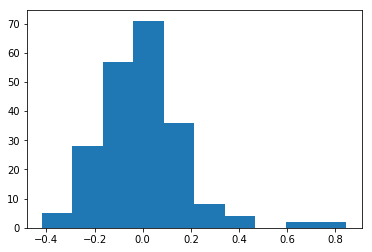

MEAN: -0.0017497946766864413
MAE: 0.1322763617270366
STD: 0.18312267782441966


In [17]:
plt.hist(df_check['diff'])
plt.show()
print("MEAN:", df_check['diff'].mean())
print("MAE:", df_check['diff'].abs().mean())
print("STD:", df_check['diff'].std())

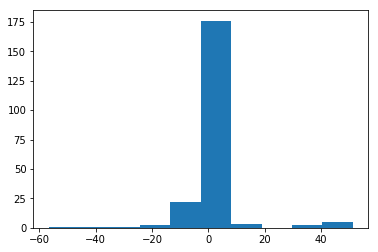

MEAN: 0.6766849656317994
MAE: 4.013002739923537
STD: 10.142118959652125


In [18]:
plt.hist(df_check['dw'])
plt.show()
print("MEAN:", df_check['dw'].mean())
print("MAE:", df_check['dw'].abs().mean())
print("STD:", df_check['dw'].std())

## sample_weightあり

In [19]:
list_y = []
for i in y.index:
    # print
    list_i = list(y.index)
    list_i.remove(i)
    print("★%s" % i)
    # X, y & Train, Valid
    X_train = X.loc[list_i]
    y_train = y.loc[list_i]
    X_valid = X.loc[i]
    y_valid = y.loc[i]
    # btr_pa（重み）を除く
    X_train_weight = X_train['btr_pa']
    X_train = X_train.drop(columns=['btr_pa'], axis=1)
    X_valid = X_valid.drop(labels=['btr_pa'])
    print(X_train.shape, X_valid.shape)
    # lgb
    lgb_train = lgb.Dataset(X_train, y_train, weight=X_train_weight)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    # model
    model = lgb.train(params, lgb_train, num_boost_round=num_round)
    # predict
    list_y.append(model.predict(X_valid)[0])

★0
(212, 17) (17,)
★1
(212, 17) (17,)
★2
(212, 17) (17,)
★3
(212, 17) (17,)
★4
(212, 17) (17,)
★5
(212, 17) (17,)
★6
(212, 17) (17,)
★7
(212, 17) (17,)
★8
(212, 17) (17,)
★9
(212, 17) (17,)
★10
(212, 17) (17,)
★11
(212, 17) (17,)
★12
(212, 17) (17,)
★13
(212, 17) (17,)
★14
(212, 17) (17,)
★15
(212, 17) (17,)
★16
(212, 17) (17,)
★17
(212, 17) (17,)
★18
(212, 17) (17,)
★19
(212, 17) (17,)
★20
(212, 17) (17,)
★21
(212, 17) (17,)
★22
(212, 17) (17,)
★24
(212, 17) (17,)
★25
(212, 17) (17,)
★26
(212, 17) (17,)
★27
(212, 17) (17,)
★28
(212, 17) (17,)
★29
(212, 17) (17,)
★30
(212, 17) (17,)
★31
(212, 17) (17,)
★33
(212, 17) (17,)
★34
(212, 17) (17,)
★35
(212, 17) (17,)
★36
(212, 17) (17,)
★37
(212, 17) (17,)
★38
(212, 17) (17,)
★39
(212, 17) (17,)
★40
(212, 17) (17,)
★41
(212, 17) (17,)
★42
(212, 17) (17,)
★43
(212, 17) (17,)
★44
(212, 17) (17,)
★46
(212, 17) (17,)
★47
(212, 17) (17,)
★48
(212, 17) (17,)
★49
(212, 17) (17,)
★50
(212, 17) (17,)
★51
(212, 17) (17,)
★52
(212, 17) (17,)
★53
(212, 

In [20]:
df_check = pd.DataFrame()
df_check['y'] = y
df_check['y_pred'] = list_y
df_check['diff'] = df_check['y'] - df_check['y_pred']
df_check['weight'] = X['btr_pa']
df_check['dw'] = df_check['diff'] * df_check['weight']

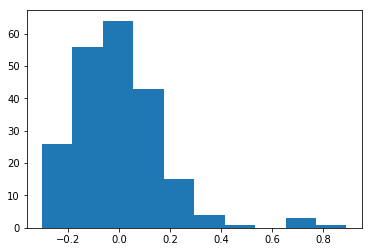

MEAN: 0.0038352179463815744
MAE: 0.127097769866711
STD: 0.17494431842443417


In [21]:
plt.hist(df_check['diff'])
plt.show()
print("MEAN:", df_check['diff'].mean())
print("MAE:", df_check['diff'].abs().mean())
print("STD:", df_check['diff'].std())

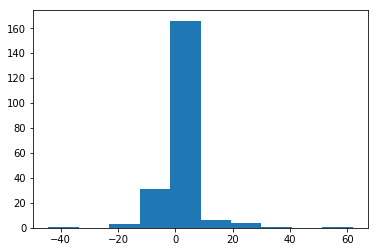

MEAN: 0.614371189810878
MAE: 3.328403506460046
STD: 7.6495407120552015


In [22]:
plt.hist(df_check['dw'])
plt.show()
print("MEAN:", df_check['dw'].mean())
print("MAE:", df_check['dw'].abs().mean())
print("STD:", df_check['dw'].std())

## 予測結果の生データ確認

In [23]:
# 打数が多いほど予測が一致しているか確認する
df_check.sort_values('weight', ascending=False)

,y,y_pred,diff,weight,dw
217,0.354671,0.313595,0.041076,676,27.767252
216,0.323340,0.217451,0.105890,585,61.945545
226,0.353881,0.316907,0.036974,576,21.297013
6,0.193384,0.130324,0.063060,488,30.773187
4,0.216080,0.192820,0.023260,473,11.002133
7,0.158854,0.138790,0.020064,464,9.309828
1,0.204545,0.172185,0.032360,451,14.594522
225,0.271233,0.306282,-0.035049,447,-15.666971
8,0.182540,0.206707,-0.024167,444,-10.730077
5,0.158442,0.118922,0.039520,436,17.230623


In [24]:
# 差が大きいほどweightが小さいかどうか確認する
df_check.sort_values('diff', ascending=False)

,y,y_pred,diff,weight,dw
87,1.000000,0.108987,0.891013,2,1.782025
30,1.000000,0.231591,0.768409,2,1.536818
141,0.800000,0.128047,0.671953,9,6.047577
97,1.000000,0.332583,0.667417,2,1.334835
175,0.600000,0.158181,0.441819,6,2.650914
262,0.500000,0.111645,0.388355,2,0.776709
65,0.545455,0.189468,0.355986,12,4.271836
92,0.500000,0.149070,0.350930,10,3.509298
154,0.500000,0.149796,0.350204,4,1.400817
123,0.421053,0.141436,0.279617,20,5.592338


# 予測結果の可視化
このデータから打撃の選手採用方針が決まる。

## SHAPでの特徴量間の変動確認

In [25]:
explainer = shap.TreeExplainer(model, data=X_train)

In [26]:
shap_values = explainer.shap_values(X_train)

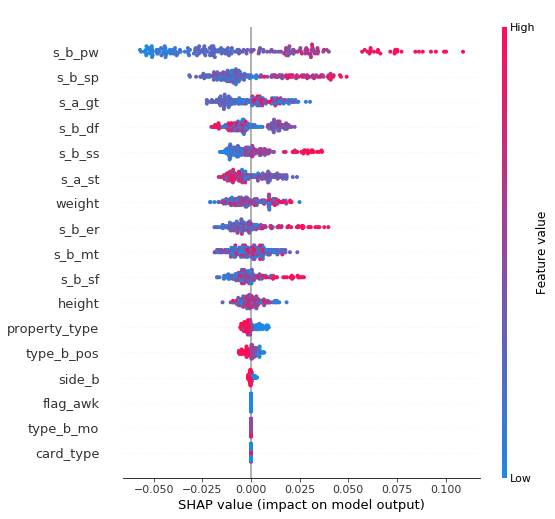

In [27]:
shap.summary_plot(shap_values=shap_values,
                  features=X_train,
                  feature_names=X_train.columns)

### 個別の変数で変動を確認

★ property_type
ラベル： ['B' 'H' 'T']


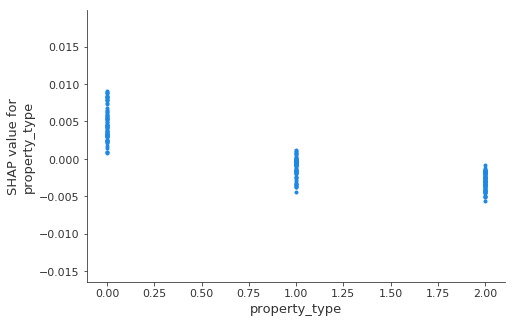

★ card_type
ラベル： ['B' 'P']


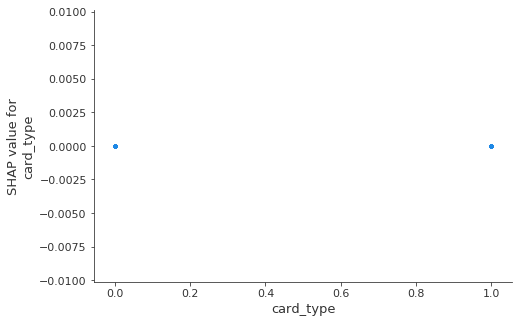

★ side_b
ラベル： ['L' 'R']


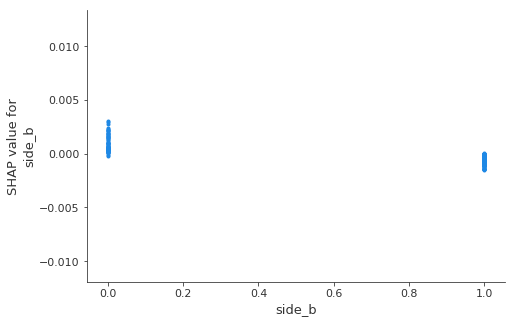

★ type_b_pos
ラベル： ['C' 'F' 'R']


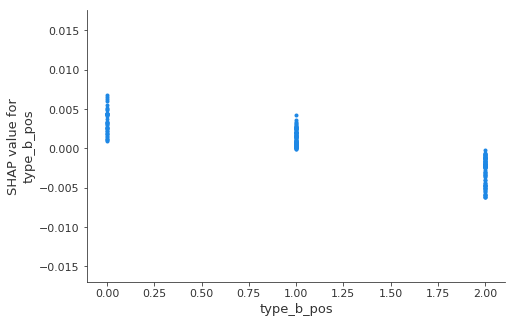

★ type_b_mo
ラベル： ['D' 'N' 'U']


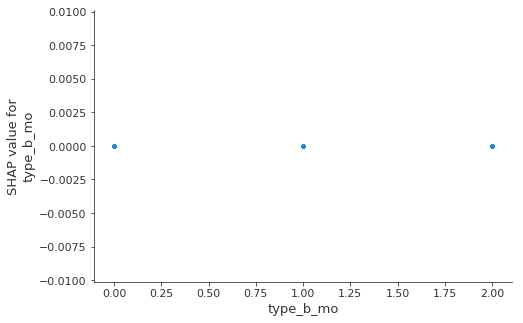

★ height


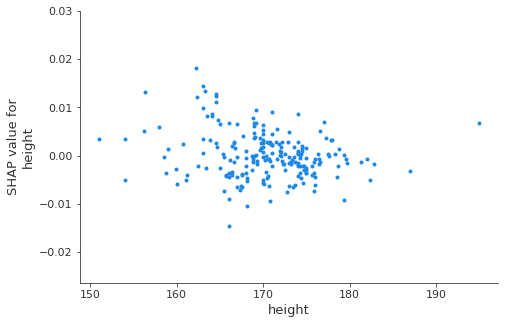

★ weight


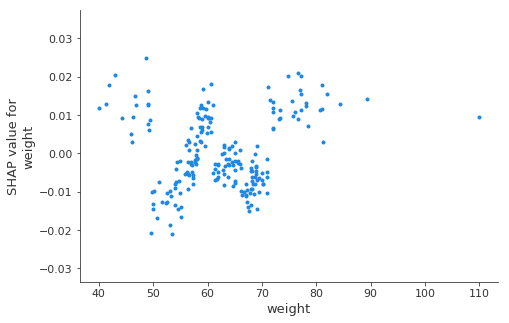

★ flag_awk
ラベル： [False  True]


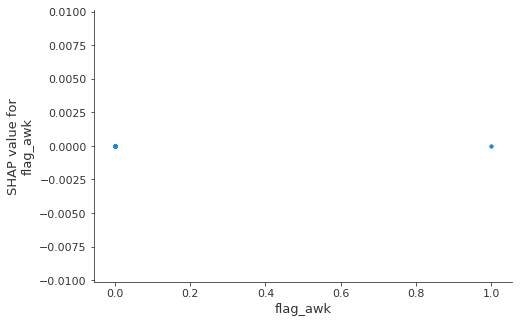

★ s_a_st


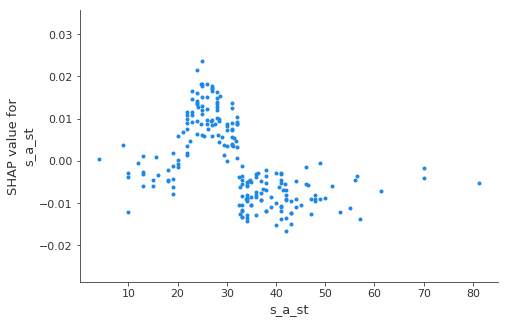

★ s_a_gt


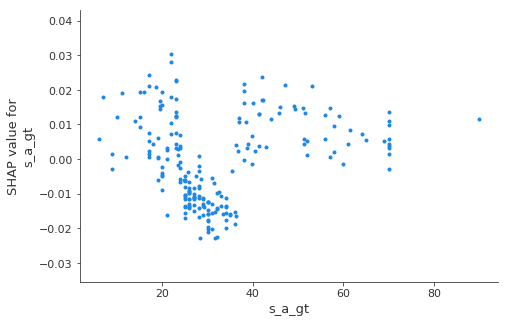

★ s_b_mt


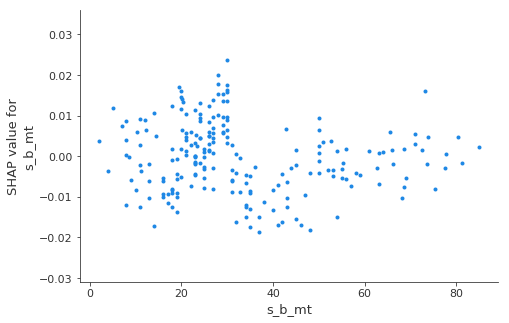

★ s_b_pw


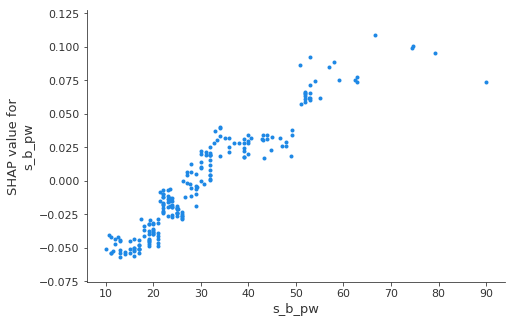

★ s_b_sp


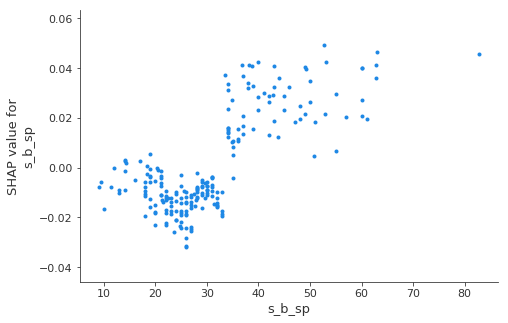

★ s_b_sf


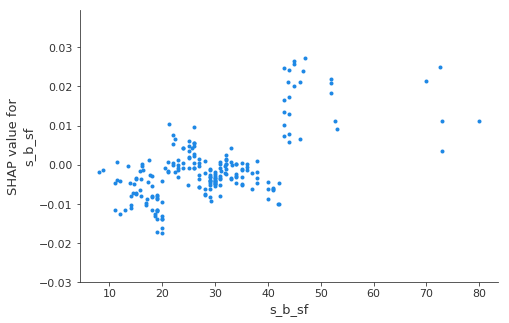

★ s_b_df


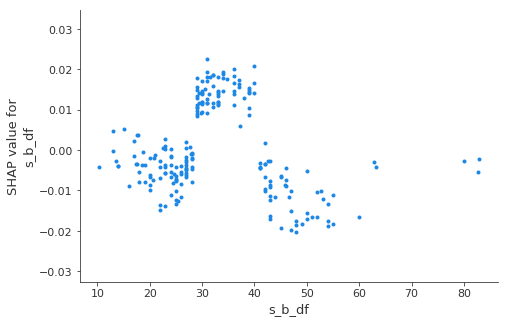

★ s_b_er


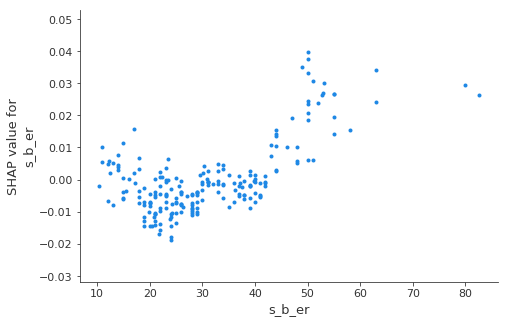

★ s_b_ss


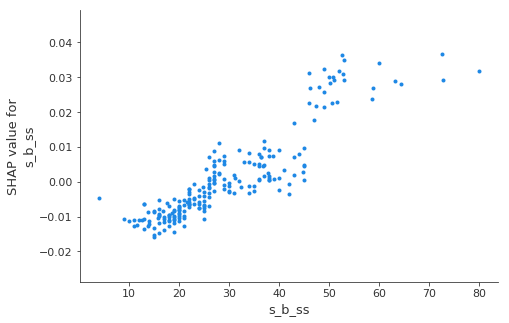

In [28]:
for col in X_train.columns:
    print("★", col)
    if col in dict_label:
        print("ラベル：", dict_label[col].classes_)
    shap.dependence_plot(ind=col,
                     interaction_index=None,
                     shap_values=shap_values,
                     features=X_train,
                     feature_names=X_train.columns)